# Generación de clusters
Notebook final para el preprocesamiento de los datos a través de pipelines, la generación de clusters y posterior exportación de su resultado.

In [1]:
from pathlib import Path
import joblib
from typing import List

import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px

from pipeline import (
    DropColumns,
    DropHighNAPercentage,
    NormalizeCurrency,
    OrdinalColumnMapper,
    DataframeOneHotEncoder,
    NanInputer,
    InfoDisplayer,
    MultiDataFramePipeline,
    MultiDataFrameMerger,
    KMeansClusterer,
)
from utils import (
    show,
)

pd.set_option("display.max_columns", None)

In [2]:
ROOT_DIR = Path.cwd().parent
DATA_DIR = ROOT_DIR / "data"

DATA_PATH = DATA_DIR / 'indices_institucional_2005_2022.xlsx'
DATA_PATH.exists()

True

In [1]:
# xlsx to pkl
# df = pd.read_excel(DATA_PATH)
# joblib.dump(df, DATA_DIR / 'base_indices.pkl')

In [3]:
df = joblib.load(DATA_DIR / "base_indices.pkl")
df = df.reset_index()
df = df[df["Promedio Puntaje (promedio matemáticas y lenguaje)"].notna()].reset_index(
    drop=True
)
df = (
    df[df["Pregrado/Posgrado"] == "Pregrado"]
    .drop(columns=["Pregrado/Posgrado"])
    .reset_index(drop=True)
    # .rename(columns={"Año": "Fecha"})
)
df["Año"] = df["Año"].dt.year

In [4]:
inmuebles, labs, docentes = joblib.load(DATA_DIR / "extra_data.pkl")


def prepare_for_merge(df_to_merge: pd.DataFrame, year_col: str) -> pd.DataFrame:
    df_to_merge["Año"] = df_to_merge[year_col].astype(int)
    df_to_merge = df_to_merge.drop(columns=[year_col])
    df_to_merge = df_to_merge.rename(columns={"idSede": "Cód. Sede"})
    df_to_merge["Cód. Sede"] = df_to_merge["Cód. Sede"].astype(int)
    df_to_merge["Cód. Institución"] = df_to_merge["Cód. Institución"].astype(int)
    df_to_merge = df_to_merge.drop(columns=["Tipo Institución", "Cód. Institución"])

    return df_to_merge


inmuebles = prepare_for_merge(inmuebles, year_col="Año Información")
labs = prepare_for_merge(labs, year_col="Año Proceso")
docentes = prepare_for_merge(docentes, year_col="Año Proceso")

### Main Data Pipeline

In [5]:
# DROP COLUMNS
COLUMNS_TO_DROP = [
    # drop por no ser relevantes
    "Nombre de la Sede",
    "Orden Geográfico de la Región (Norte aSur)",
    "Mención o Especialidad",
    "idgenerocarrera",
    "Códgo SIES",
    "Máximo Puntaje (promedio matemáticas y lenguaje)",
    "Máximo Puntaje NEM",
    "Máximo Puntaje Ranking",
    "Mínimo Puntaje (promedio matemáticas y lenguaje)",
    "Mínimo Puntaje NEM",
    "Mínimo Puntaje Ranking",
    # drop por decision de mining
    "Grado Académico",
    "Cód. Institución",
    "Nombre Region",
    "Carrera Genérica",
    "Cód. Carrera",
    "Nombre Programa",
    "Nombre del Campus",
    "Título",
]

# DROP HIGH NA COLUMNS
EXCLUDE_COLUMNS_OF_DROPHIGHNA = ["Nombre del Campus"]

# NORMALIZE CURRENCY
CURRENCY_COLUMNS = [
    "Valor de matrícula",
    "Valor de arancel",
    "Valor del Título",
]

# ORDINAL ENCODER
m_class1 = {
    "(a) Universidades CRUCH": 0,
    "(b) Universidades Privadas": 1,
    "(c) Institutos Profesionales": 2,
    "(d) Centros de Formación Técnica": 3,
    "(e) Centros de Formación Técnica Estatales": 3,
    "(f) F.F.A.A.": 4,
}

m_class2 = {
    "(a) Universidades Estatales CRUCH": 0,
    "(b) Universidades Privadas CRUCH": 1,
    "(c) Univ. Privadas Adscritas SUA": 2,
    "(d) Universidades Privadas": 3,
    "(e) Institutos Profesionales": 4,
    "(f) Centros de Formación Técnica": 5,
    "(g) Centros de Formación Técnica statales": 5,
    "(h) F.F.A.A.": 6,
}

m_class3 = {"(a) Acreditada": 0, "(b) No Acreditada": 1}

m_class4 = {
    "(a) Autónoma": 0,
    "(b) Licenciamiento": 1,
    "(c) Examinación": 2,
    "(d) Supervisión": 3,
    "(e) F.F.A.A.": 4,
    "(e) Cerrada": 5,
}

m_class5 = {"(a) Adscritas a Gratuidad": 0, "(b) No Adscritas/No Aplica": 1}

m_class6 = {
    "(a) Subsistema Universitario": 0,
    "(b) Subsistema Técnico Profesional": 1,
    "(c) No adscrito": 2,
    "(d) F.F.A.A.": 3,
}

m_inst = {
    "Univ.": 0,
    "I.P.": 1,
    "C.F.T.": 2,
    "F.F.A.A.": 3,
}

m_tipo_programa = {"Programa Regular": 0, "Programa Especial": 1}

m_tipo_carrera = {
    "Profesional con Licenciatura": 0,
    "Técnico Nivel Superior": 3,
    "Profesional": 1,
    "Licenciatura": 2,
    "Bachillerato": 4,
    "Plan Común o Ciclo Básico": 4,
}

m_tipo_ingreso = {"Ingreso Directo": 0, "No es Ingreso Directo": 1}

COLUMNS_TO_MAP = [f"Clasificación{i}" for i in range(1, 7)]
COLUMNS_TO_MAP.extend(
    [
        "Tipo Institución",
        "Tipo Programa",
        "Tipo Carrera",
        "IngresoDirecto",
    ]
)
MAPPINGS = [
    m_class1,
    m_class2,
    m_class3,
    m_class4,
    m_class5,
    m_class6,
    m_inst,
    m_tipo_programa,
    m_tipo_carrera,
    m_tipo_ingreso,
]

# ONE HOT ENCODER
COLUMNS_TO_ONE_HOT = [
    "Nombre Institución",
    "Comuna donde se imparte la carrera o programa",
    "Area Conocimiento",
    "Horario",
]

In [6]:
data_pipeline = Pipeline(
    steps=[
        # ("info_displayer1", InfoDisplayer(name="Original Data")),
        (
            "drop_columns",
            DropColumns(
                columns=COLUMNS_TO_DROP,
            ),
        ),
        # ("info_displayer2", InfoDisplayer(name="After Drop Columns")),
        (
            "drop_high_na",
            DropHighNAPercentage(
                na_threshold=0.24, exclude=EXCLUDE_COLUMNS_OF_DROPHIGHNA
            ),
        ),
        # ("info_displayer3", InfoDisplayer(name="After Drop High NA")),
        (
            "preprocess_tipo_moneda",
            NormalizeCurrency(columns=CURRENCY_COLUMNS),
        ),
        # ("info_displayer4", InfoDisplayer(name="After Normalize Currency")),
        (
            "ordinal_encoder",
            OrdinalColumnMapper(columns=COLUMNS_TO_MAP, mappings=MAPPINGS),
        ),
        # ("info_displayer5", InfoDisplayer(name="After Ordinal Encoder")),
        (
            "one_hot_encoder",
            DataframeOneHotEncoder(
                columns=COLUMNS_TO_ONE_HOT,
                min_frequency=20,
                # max_categories=30,
            ),
        ),
        # ("info_displayer6", InfoDisplayer(name="After One Hot Encoder")),
        (
            "nan_inputer",
            NanInputer(n_neighbors=5, columns="auto"),
        ),
        # ("info_displayer7", InfoDisplayer(name="After Nan Inputer")),
    ],
    # verbose=True,
)

### Data to merge pipelines

In [7]:
inmuebles_pipe = Pipeline(
    steps=[
        (
            "drop_columns",
            DropColumns(
                columns=["Nombre Institución", "Sede", "idInstitucion"], errors="ignore"
            ),
        ),
        ("drop_high_na", DropHighNAPercentage(na_threshold=0.3, exclude=[])),
        ("inputer", NanInputer(n_neighbors=5)),
    ]
)

labs_pipe = Pipeline(
    steps=[
        (
            "drop_columns",
            DropColumns(
                columns=["Nombre Institución", "Sede", "idInstitucion"], errors="ignore"
            ),
        ),
        ("drop_high_na", DropHighNAPercentage(na_threshold=0.3, exclude=[])),
        ("inputer", NanInputer(n_neighbors=5)),
    ]
)

docentes_pipe = Pipeline(
    steps=[
        (
            "drop_columns",
            DropColumns(
                columns=["Nombre Institución", "Sede", "idInstitucion"], errors="ignore"
            ),
        ),
        ("drop_high_na", DropHighNAPercentage(na_threshold=0.3, exclude=[])),
        ("inputer", NanInputer(n_neighbors=5)),
    ]
)

In [9]:
MERGE_COLS = [
    "Año",
    "Cód. Sede",
]

multi_pipe = MultiDataFramePipeline(
    transformers=[
        ("data_processor", data_pipeline),
        ("inmuebles_processor", inmuebles_pipe),
        ("labs_processor", labs_pipe),
        ("docentes_processor", docentes_pipe),
    ]
)

pipe_merger = MultiDataFrameMerger(columns=MERGE_COLS)

data_processor = Pipeline(
    [
        ("multi_pipe", multi_pipe),
        ("pipe_merger", pipe_merger),
        ("drop_join_cols", DropColumns(columns=["Cód. Sede"])),
        (
            "variance_threshold",
            VarianceThreshold(threshold=0.1).set_output(transform="pandas"),
        ),
        (
            "scaler",
            StandardScaler().set_output(transform="pandas"),
        ),
        (
            "kmeans",
            KMeansClusterer(
                n_clusters=[n for n in range(3, 7)],
                random_state=42,
                progress_bar=True,
            ),
        ),
    ]
)

In [10]:
processed_data = data_processor.fit_transform(
    [
        df,
        inmuebles,
        labs,
        docentes,
    ]
)

Fitting Pipeline...
Fitting Pipeline...
Fitting Pipeline...
Fitting Pipeline...
Returning 4 DataFrames.
Merging 4 DataFrames into one...


KMeans: 100%|██████████| 4/4 [01:21<00:00, 20.47s/it]


In [11]:
show(processed_data)

(30607, 54)


,Año,Clasificación1,Clasificación2,Clasificación5,Clasificación6,Tipo Carrera,Año Inicio Actividades,Duración (en semestres),Promedio Puntaje (promedio matemáticas y lenguaje),Puntaje de corte (primer seleccionado),Puntaje de corte (promedio de la carrera),Puntaje de corte (último seleccionado),Nº Alumnos Ingreso Via PSU o PDT,Valor de matrícula,Valor de arancel,Valor del Título,Vacantes,Matrícula primer año hombres,Matrícula primer año mujeres,Matrícula Primer Año,Matrícula total hombres,Matrícula total mujeres,Matrícula Total,Comuna donde se imparte la carrera o programa_Santiago,Area Conocimiento_Educación,Area Conocimiento_Salud,Area Conocimiento_Tecnología,N° Inmuebles,M2 Terreno,M2 Construido_x,M2 Salas,Nº Oficinas,Nº Salas,Nº Laboratorios,M2 Construido_y,Nº de PC para alumnos,N° Computadores con Internet,N°DocentesJornadaMedia,N°DocentesJornadaHora,N°DocentesJornadaCompleta,N°HorasJornadaCompleta,N°HorasJornadaMedia,N°HorasJornadaHora,N°HorasProfJornadaHora,N°HorasProfJornadaMedia,N°HorasProfJornadaCompleta,N°ProfesionalJornadaHora,N°ProfesionalJornadaMedia,N°ProfesionalJornadaCompleta,N°Docentes,N°Horas,N°DocentesHombres,N°DocentesMujeres,cluster
2058,1.527333,-0.939765,-1.236585,-0.864796,-0.433558,-0.405789,-2.351078,0.840716,0.772211,1.971491,1.510276,1.426788,1.581666,-0.185707,1.260294,-0.309861,1.426361,0.935102,1.553781,1.443578,1.170592,2.015683,1.796461,1.924501,-0.494204,-0.47322,-0.484202,1.887713,7.532065,5.395812,4.070797,4.273054,3.512492,3.202869,3.53246,2.780025,1.744646,4.20931,1.944885,3.911184,3.794827,3.957866,2.363268,0.779662,2.174584,1.343619,0.530521,2.373232,1.625348,3.321297,3.855726,3.266966,3.259209,2
2059,1.527333,-0.939765,-1.236585,-0.864796,-0.433558,-0.405789,0.815388,0.315148,1.269192,1.098800,1.846101,1.873095,0.772704,-0.185707,2.187658,-0.309861,0.226372,0.504482,0.622919,0.661847,0.450956,0.570538,0.582088,1.924501,-0.494204,-0.47322,-0.484202,1.887713,7.532065,5.395812,4.070797,4.273054,3.512492,3.202869,3.53246,2.780025,1.744646,4.20931,1.944885,3.911184,3.794827,3.957866,2.363268,0.779662,2.174584,1.343619,0.530521,2.373232,1.625348,3.321297,3.855726,3.266966,3.259209,2
2060,1.527333,-0.939765,-1.236585,-0.864796,-0.433558,-0.405789,-3.961145,0.315148,2.102838,2.001074,2.484168,2.450669,6.698350,-0.185707,2.700965,-0.309861,6.495281,7.308279,6.573785,8.224641,8.742691,6.805936,9.012186,1.924501,-0.494204,-0.47322,-0.484202,1.887713,7.532065,5.395812,4.070797,4.273054,3.512492,3.202869,3.53246,2.780025,1.744646,4.20931,1.944885,3.911184,3.794827,3.957866,2.363268,0.779662,2.174584,1.343619,0.530521,2.373232,1.625348,3.321297,3.855726,3.266966,3.259209,2
2061,1.527333,-0.939765,-1.236585,-0.864796,-0.433558,-0.405789,0.815388,0.315148,1.381414,1.365045,1.795727,1.833715,2.370404,-0.185707,2.187658,-0.309861,1.674635,1.882466,1.686761,2.116231,1.775595,1.678238,1.988410,1.924501,-0.494204,-0.47322,-0.484202,1.887713,7.532065,5.395812,4.070797,4.273054,3.512492,3.202869,3.53246,2.780025,1.744646,4.20931,1.944885,3.911184,3.794827,3.957866,2.363268,0.779662,2.174584,1.343619,0.530521,2.373232,1.625348,3.321297,3.855726,3.266966,3.259209,2
2062,1.527333,-0.939765,-1.236585,-0.864796,-0.433558,-0.405789,-4.444165,0.315148,0.740148,1.498167,1.459902,1.164254,0.530016,-0.185707,1.856037,-0.309861,1.943598,0.504482,0.124243,0.389150,1.724648,1.076705,1.635850,-0.519615,-0.494204,-0.47322,-0.484202,1.887713,7.532065,5.395812,4.070797,4.273054,3.512492,3.202869,3.53246,2.780025,1.744646,4.20931,1.944885,3.911184,3.794827,3.957866,2.363268,0.779662,2.174584,1.343619,0.530521,2.373232,1.625348,3.321297,3.855726,3.266966,3.259209,2


<Axes: xlabel='n_clusters'>

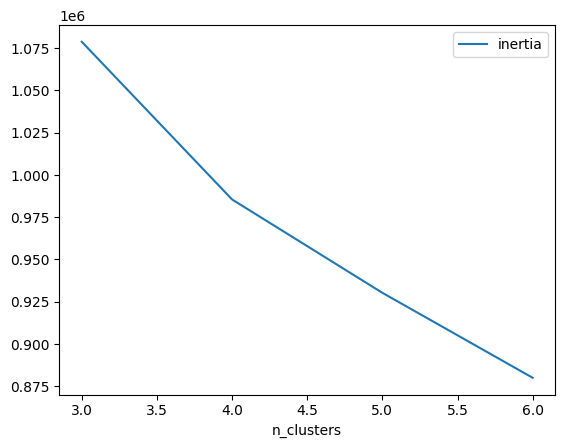

In [18]:
data_processor['kmeans'].results_df.plot(y='inertia', kind='line')

In [19]:
pca = PCA(n_components=2)
pca.fit(processed_data.drop(columns=['cluster']))
pca.explained_variance_ratio_

array([0.37530889, 0.11446921])

In [20]:
labels = data_processor['kmeans'].get_labels(n_clusters=4) 
fig = px.scatter(
    pca.transform(processed_data.drop(columns=['cluster'])),
    x=0,
    y=1,
    color=labels,
)
fig.show()

In [21]:
result = df.loc[processed_data.index].copy()
result['cluster'] = labels

In [59]:
result.to_csv(DATA_DIR / 'result.csv', index=False)